# Autoencoder + Random Forest

## Preparing Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('../../dataset2001_2024.csv')
data.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_UV_INDEX,ALLSKY_SRF_ALB,CLRSKY_KT,CLOUD_AMT,T2M,PS,PW,WD10M,WD50M,WS50M,WS10M,TOA_SW_DNI,QV2M,QV10M
0,2001,1,1,0,0.0,-999.0,-999.0,32.70,18.93,93.39,2.72,140.07,139.57,6.24,4.25,0.0,13.79,13.73
1,2001,1,1,1,0.0,-999.0,-999.0,24.88,18.54,93.40,2.66,138.43,137.82,6.18,4.06,0.0,13.55,13.49
2,2001,1,1,2,0.0,-999.0,-999.0,51.42,18.21,93.36,2.61,138.09,137.45,6.08,3.89,0.0,13.37,13.31
3,2001,1,1,3,0.0,-999.0,-999.0,66.36,17.94,93.31,2.55,137.70,136.99,5.89,3.63,0.0,13.18,13.18
4,2001,1,1,4,0.0,-999.0,-999.0,51.16,17.69,93.27,2.50,137.93,137.20,5.62,3.35,0.0,13.06,13.06


# Criando nova coluna para datas

data = data.astype({'MO' : 'str'})
data = data.astype({'DY' : 'str'})
data = data.astype({'HR' : 'str'})

data['timeStamp'] = data.apply(lambda row: f"{row['YEAR']}{row['MO']}{row['DY']}{row['HR']}", axis=1)
data.loc[:, 'MO'] = data['MO'].apply(lambda x: f'{int(x):02d}')
data.loc[:, 'DY'] = data['DY'].apply(lambda x: f'{int(x):02d}')
data.loc[:, 'HR'] = data['HR'].apply(lambda x: f'{int(x):02d}')

def convert_to_timestamp(date_str):
    if date_str and len(date_str):
        year = int(date_str[0:4])  # Extrai o ano
        month = int(date_str[4:6]) # Extrai o mês
        day = int(date_str[6:8])   # Extrai o dia
        hour = int(date_str[8:10]) # Extrai a hora
        return pd.Timestamp(year, month, day, hour)
    else:
        return pd.NaT

data['timeStamp'] = data['timeStamp'].apply(convert_to_timestamp)

In [3]:
data.info

<bound method DataFrame.info of         YEAR  MO  DY  HR  ALLSKY_SFC_UV_INDEX  ALLSKY_SRF_ALB  CLRSKY_KT  \
0       2001   1   1   0                 0.00         -999.00    -999.00   
1       2001   1   1   1                 0.00         -999.00    -999.00   
2       2001   1   1   2                 0.00         -999.00    -999.00   
3       2001   1   1   3                 0.00         -999.00    -999.00   
4       2001   1   1   4                 0.00         -999.00    -999.00   
...      ...  ..  ..  ..                  ...             ...        ...   
201595  2023  12  31  19                 2.92            0.15       0.67   
201596  2023  12  31  20                 0.80            0.13       0.58   
201597  2023  12  31  21                 0.05            0.16       0.38   
201598  2023  12  31  22                 0.00         -999.00    -999.00   
201599  2023  12  31  23                 0.00         -999.00    -999.00   

        CLOUD_AMT    T2M     PS    PW   WD10M   WD50M  

data = data.set_index(data['timeStamp'])
data

In [5]:
data[['ALLSKY_SRF_ALB', 'CLRSKY_KT']] = data[['ALLSKY_SRF_ALB', 'CLRSKY_KT']].replace(-999.00, 0)


In [6]:
# Adicionando features sazonais baseadas em MO e HR
data['MO_sin'] = np.sin(2 * np.pi * data['MO'].astype(int) / 12)
data['MO_cos'] = np.cos(2 * np.pi * data['MO'].astype(int) / 12)
data['HR_sin'] = np.sin(2 * np.pi * data['HR'].astype(int) / 24)
data['HR_cos'] = np.cos(2 * np.pi * data['HR'].astype(int) / 24)

In [8]:
columns = [
    'T2M',
    'YEAR',
    'MO',
    'DY',
    'HR',
    #'timeStamp'
]

X = data.drop(columns=columns)
y = data['T2M']

## Splitting into Training (2001 > 2023) and Test (2023)

In [9]:
# Dividindo os dados em treino (2001-2022) e teste (2023)
X_train = X[data['YEAR'] < 2023]
y_train = y[data['YEAR'] < 2023]
X_test = X[data['YEAR'] == 2023]
y_test = y[data['YEAR'] == 2023]

In [10]:
# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Importando TF
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

## Using Autoencoder to perform SSL

In [12]:
# Dimensão das features de entrada
input_dim = X_train_scaled.shape[1]

# Construindo o Autoencoder
input_layer = Input(shape=(input_dim,))
# Encoder
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
# Bottleneck
bottleneck = Dense(16, activation='relu', name="bottleneck")(encoded)
# Decoder
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

In [13]:
# Definindo o modelo de Autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
# Treinamento do Autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Entrada e saída são iguais
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - loss: 0.3024 - val_loss: 0.0206
Epoch 2/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.0141 - val_loss: 0.0081
Epoch 3/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.0074 - val_loss: 0.0058
Epoch 4/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0053 - val_loss: 0.0045
Epoch 5/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 6/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.0049 - val_loss: 0.0034
Epoch 7/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0031 - val_loss: 0.0025
Epoch 9/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 11/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 12/50
678/678 ━━━━━━━━━━

## Results

In [15]:
# Extraindo o modelo encoder (bottleneck)
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)

# Gerando representações reduzidas dos dados
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Treinando um modelo supervisionado usando as representações reduzidas
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modelo de regressão (Random Forest)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_encoded, y_train)

# Prevendo as temperaturas para o ano de 2023
y_pred = regressor.predict(X_test_encoded)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


6027/6027 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
MSE: 3.6277
MAE: 1.2790
R²: 0.8855


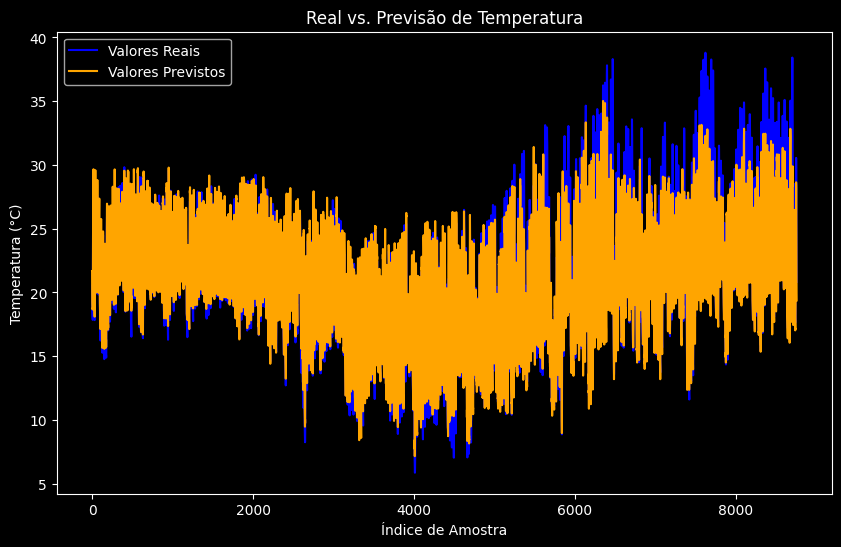

In [16]:
import matplotlib.pyplot as plt

# Plotando Real vs Previsão
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reais', color='blue')
plt.plot(y_pred, label='Valores Previstos', color='orange')
plt.title('Real vs. Previsão de Temperatura')
plt.xlabel('Índice de Amostra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


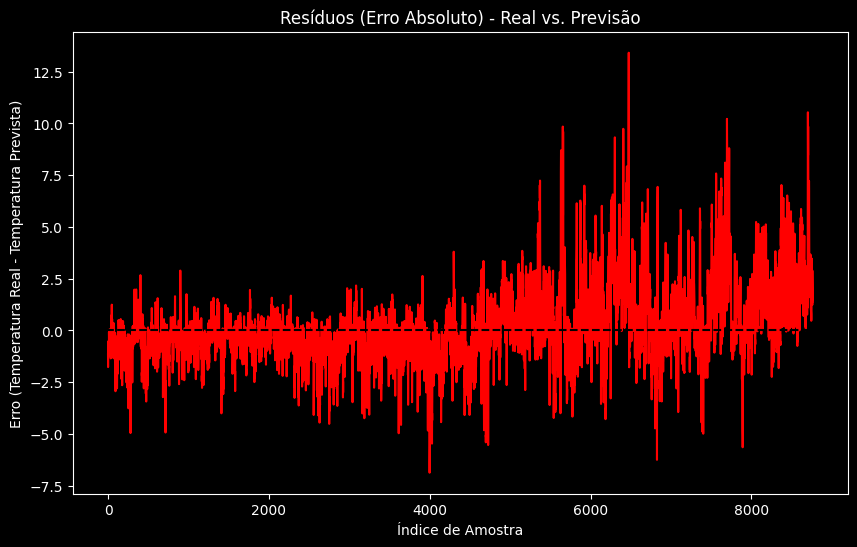

In [17]:
# Calculando e plotando os resíduos
residuals = y_test.values - y_pred

plt.figure(figsize=(10, 6))
plt.plot(residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Resíduos (Erro Absoluto) - Real vs. Previsão')
plt.xlabel('Índice de Amostra')
plt.ylabel('Erro (Temperatura Real - Temperatura Prevista)')
plt.show()


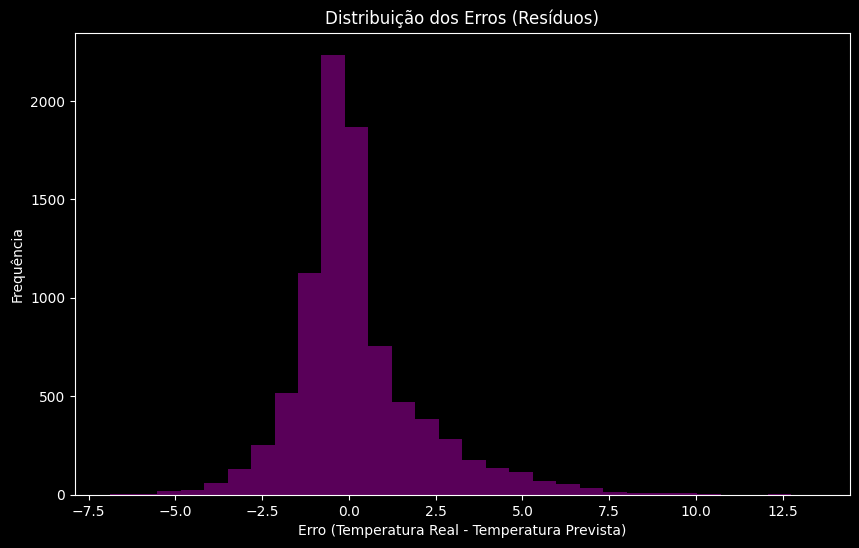

In [18]:
# Plotando histograma dos erros
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro (Temperatura Real - Temperatura Prevista)')
plt.ylabel('Frequência')
plt.show()


# Autoencoder + TensorFlow

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
def build_nn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Saída para regressão
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

In [21]:
# Construção do modelo
input_dim = X_train_encoded.shape[1]  # Dimensão da entrada do bottleneck
nn_model = build_nn(input_dim)

# Treinamento do modelo com early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history = nn_model.fit(
    X_train_encoded, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 4s 702us/step - loss: 19.3204 - mae: 2.9097 - val_loss: 7.3414 - val_mae: 2.0920
Epoch 2/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 685us/step - loss: 4.1251 - mae: 1.5130 - val_loss: 12.4772 - val_mae: 2.8467
Epoch 3/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 687us/step - loss: 3.3379 - mae: 1.3366 - val_loss: 9.4762 - val_mae: 2.4368
Epoch 4/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 683us/step - loss: 3.0484 - mae: 1.2745 - val_loss: 8.8342 - val_mae: 2.3486
Epoch 5/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 683us/step - loss: 2.8988 - mae: 1.2318 - val_loss: 7.2225 - val_mae: 2.0730
Epoch 6/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 686us/step - loss: 2.7823 - mae: 1.2068 - val_loss: 6.0550 - val_mae: 1.8956
Epoch 7/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 682us/step - loss: 2.6913 - mae: 1.1873 - val_loss: 6.3326 - val_mae: 1.9070
Epoch 8/100
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 3s 686us/step - loss: 2.6619 - mae: 1.1794 - val_loss: 5.4789 - val_mae: 1.7793
Epoch 9/100
48

In [23]:
# Avaliação no conjunto de teste
nn_predictions = nn_model.predict(X_test_encoded)
mse_nn = mean_squared_error(y_test, nn_predictions)
mae_nn = mean_absolute_error(y_test, nn_predictions)
r2_nn = r2_score(y_test, nn_predictions)

print(f"MSE (NN): {mse_nn:.4f}")
print(f"MAE (NN): {mae_nn:.4f}")
print(f"R² (NN): {r2_nn:.4f}")

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
MSE (NN): 5.5241
MAE (NN): 1.6424
R² (NN): 0.8257


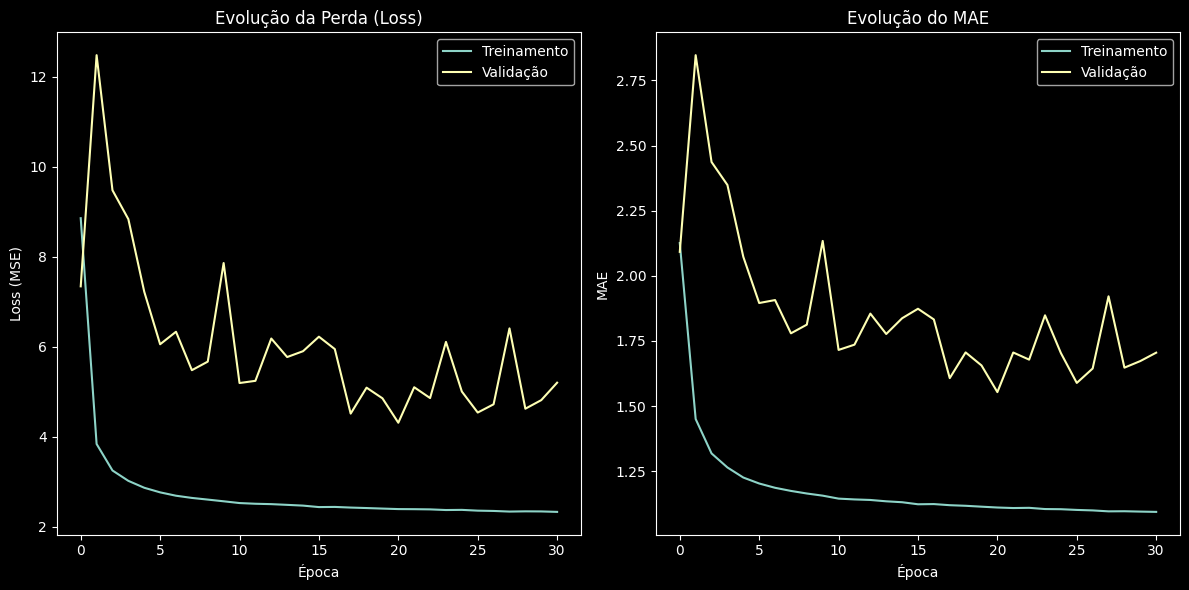

In [24]:
# Importando biblioteca para gráficos
import matplotlib.pyplot as plt

# Função para plotar a evolução do treinamento
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Perda (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treinamento')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Evolução da Perda (Loss)')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Treinamento')
    plt.plot(history.history['val_mae'], label='Validação')
    plt.title('Evolução do MAE')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Chamando a função de plotagem
plot_training_history(history)


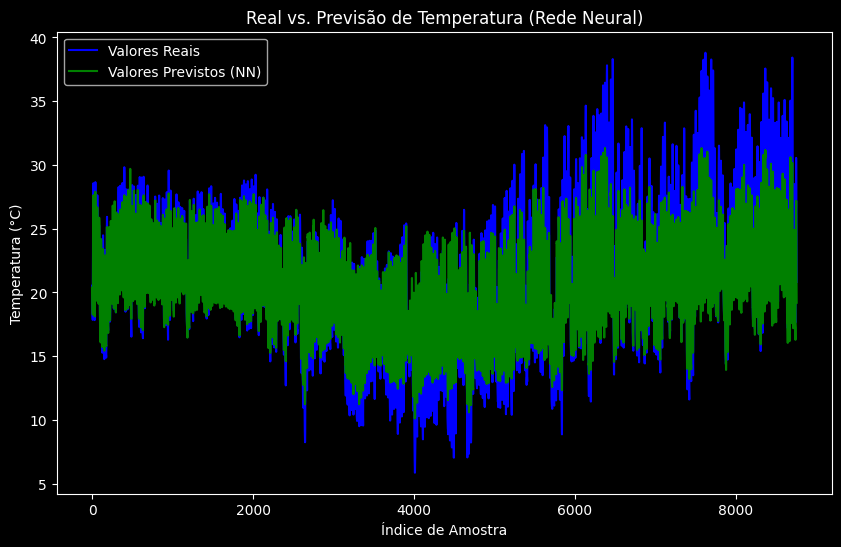

In [25]:
# Plotando valores reais vs. previstos
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reais', color='blue')
plt.plot(nn_predictions, label='Valores Previstos (NN)', color='green')
plt.title('Real vs. Previsão de Temperatura (Rede Neural)')
plt.xlabel('Índice de Amostra')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()


# Ensemble Models

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Função para criar o modelo de rede neural Keras
class KerasNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = None

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.input_dim, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))  # Camada de saída com uma unidade (previsão contínua)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=50, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Gerar as representações latentes do autoencoder para os dados de treino e teste
X_train_latents = encoder.predict(X_train)
X_test_latents = encoder.predict(X_test)

# Verifique a forma das representações latentes
print(f"Forma das representações latentes de treino: {X_train_latents.shape}")
print(f"Forma das representações latentes de teste: {X_test_latents.shape}")

# Criar o modelo KerasRegressor usando o wrapper customizado
nn_model = KerasNNRegressor(input_dim=X_train_latents.shape[1])

# Criar o StackingRegressor com os modelos (RF, LGB e NN)
stacking_model = StackingRegressor(estimators=[
    ('rf', rf_model), 
    ('lgb', lgb_model),
    ('nn', nn_model)
], final_estimator=Ridge())

# Treinar o modelo de Stacking com as representações latentes
stacking_model.fit(X_train_latents, y_train)

# Fazer previsões com o modelo de Stacking
stacking_preds = stacking_model.predict(X_test_latents)

# Avaliar os resultados
mse = mean_squared_error(y_test, stacking_preds)
mae = mean_absolute_error(y_test, stacking_preds)
r2 = r2_score(y_test, stacking_preds)

print(f'MSE (Stacking com Latentes): {mse:.4f}')
print(f'MAE (Stacking com Latentes): {mae:.4f}')
print(f'R² (Stacking com Latentes): {r2:.4f}')

# Comparar com os modelos individuais (RF, LGB, NN) também utilizando latentes
rf_preds = rf_model.predict(X_test_latents)
lgb_preds = lgb_model.predict(X_test_latents)
nn_preds = nn_model.predict(X_test_latents)

print(f'MSE (RF com Latentes): {mean_squared_error(y_test, rf_preds):.4f}')
print(f'MSE (LGB com Latentes): {mean_squared_error(y_test, lgb_preds):.4f}')
print(f'MSE (NN com Latentes): {mean_squared_error(y_test, nn_preds):.4f}')


6027/6027 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
Forma das representações latentes de treino: (192840, 16)
Forma das representações latentes de teste: (8760, 16)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 192840, number of used features: 15
[LightGBM] [Info] Start training from score 20.239449


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 154272, number of used features: 15
[LightGBM] [Info] Start training from score 20.206639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 154272, number of used features: 15
[LightGBM] [Info] Start training from score 20.405675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 154272, number of used features: 15
[LightGBM] [Info] Star

c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
MSE (Stacking com Latentes): 8.1657
MAE (Stacking com Latentes): 1.9782
R² (Stacking com Latentes): 0.7423


c:\Users\Natan Guedes\Documents\Dev\PFC\pfc\py9\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 16 features, but RandomForestRegressor is expecting 17 features as input.

NameError: name 'rf_model' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Garantir que os dados latentes sejam consistentes
X_train_latents = encoder.predict(X_train)
X_test_latents = encoder.predict(X_test)

# Diagnóstico das formas
print(f"Treino latentes: {X_train_latents.shape}")
print(f"Teste latentes: {X_test_latents.shape}")

# Ajustar os dados caso o número de features seja inconsistente
if X_train_latents.shape[1] < 17:
    cols_to_add = 17 - X_train_latents.shape[1]
    X_train_latents = np.hstack([X_train_latents, np.zeros((X_train_latents.shape[0], cols_to_add))])
    X_test_latents = np.hstack([X_test_latents, np.zeros((X_test_latents.shape[0], cols_to_add))])

# Recriar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_latents, y_train)

# Recriar o modelo LGBM
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train_latents, y_train)

# Criar a classe personalizada para a rede neural
class KerasNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = None

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.input_dim, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))  # Camada de saída
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=50, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Criar o modelo neural e treinar
nn_model = KerasNNRegressor(input_dim=X_train_latents.shape[1])
nn_model.fit(X_train_latents, y_train)

# Avaliar modelos individuais
rf_preds = rf_model.predict(X_test_latents)
lgb_preds = lgb_model.predict(X_test_latents)
nn_preds = nn_model.predict(X_test_latents).flatten()

rf_mse = mean_squared_error(y_test, rf_preds)
lgb_mse = mean_squared_error(y_test, lgb_preds)
nn_mse = mean_squared_error(y_test, nn_preds)

rf_r2 = r2_score(y_test, rf_preds)
lgb_r2 = r2_score(y_test, lgb_preds)
nn_r2 = r2_score(y_test, nn_preds)

print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")
print(f"LGBM - MSE: {lgb_mse:.4f}, R²: {lgb_r2:.4f}")
print(f"Neural Network - MSE: {nn_mse:.4f}, R²: {nn_r2:.4f}")

# Criar o ensemble com os três modelos
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('lgb', lgb_model),
        ('nn', nn_model)
    ],
    final_estimator=Ridge()
)

# Treinar o modelo de ensemble
stacking_model.fit(X_train_latents, y_train)

# Fazer previsões com o modelo de ensemble
stacking_preds = stacking_model.predict(X_test_latents)

# Avaliar o ensemble
ensemble_mse = mean_squared_error(y_test, stacking_preds)
ensemble_mae = mean_absolute_error(y_test, stacking_preds)
ensemble_r2 = r2_score(y_test, stacking_preds)

print(f"Ensemble - MSE: {ensemble_mse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")


NameError: name 'encoder' is not defined